#RSM8521 Assignment 3
# Humza Azhar Butt

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tqdm.keras import TqdmCallback

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [4]:
# This will ask you to give Colab permission to access your Google Drive 
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
path = '/content/drive/My Drive/Colab Notebooks/RSM8521 - Assignment 3/'

In [6]:
promos = pd.read_csv(path + '/promos.csv.gz')
#promos=pd.get_dummies(promos, 
 #                       prefix=['c'], 
  #                      columns=["category"])
promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   promo         24 non-null     int64  
 1   category      24 non-null     int64  
 2   promoqty      24 non-null     int64  
 3   manufacturer  24 non-null     int64  
 4   promoval      24 non-null     float64
 5   brand         24 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 1.2 KB


In [7]:
train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         20000 non-null  int64         
 1   store      20000 non-null  int64         
 2   promo      20000 non-null  int64         
 3   region     20000 non-null  int64         
 4   promodate  20000 non-null  datetime64[ns]
 5   active     20000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 937.6 KB


In [8]:
test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         10000 non-null  int64         
 1   store      10000 non-null  int64         
 2   promo      10000 non-null  int64         
 3   region     10000 non-null  int64         
 4   promodate  10000 non-null  datetime64[ns]
 5   active     0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 468.9 KB


In [9]:
test_history = pd.merge(test_history,promos, on=["promo"])

In [10]:
transactions = pd.read_csv(path + 'transactions.csv.gz', parse_dates=['date'])

In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34184139 entries, 0 to 34184138
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   store         int64         
 2   market_group  int64         
 3   category      int64         
 4   manufacturer  int64         
 5   brand         int64         
 6   date          datetime64[ns]
 7   productsize   float64       
 8   measure       object        
 9   qty           int64         
 10  amt           float64       
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)
memory usage: 2.8+ GB


In [12]:
#Add Day of Week transaction occured
transactions['Day'] = transactions['date'].dt.dayofweek

In [13]:
#Total size of all products purchased per transactions
transactions["productsize_qty"]=transactions["productsize"]*transactions["qty"]

In [14]:
#Merge promot and train history datasets together
result = pd.merge(train_history,promos, on=["promo"])

In [15]:
#Multiply promotion value with promotion quantity
result["promototal"]=result["promoval"]*result["promoqty"]
test_history["promototal"]=test_history["promoval"]*test_history["promoqty"]

In [16]:
#Groupby into dataframe for future merging
a=transactions.groupby('store').mean()
b=transactions.groupby('id').max()

In [17]:
#Avereage Sales on different Day of Week by customer ID
d=transactions.groupby(['id','Day']).mean()

In [18]:
#Different day of week average aggreagation data
day1=d.xs(0, level='Day', drop_level=False)
day2=d.xs(1, level='Day', drop_level=False)
day3=d.xs(2, level='Day', drop_level=False)
day4=d.xs(3, level='Day', drop_level=False)
day5=d.xs(4, level='Day', drop_level=False)
day6=d.xs(5, level='Day', drop_level=False)
day7=d.xs(6, level='Day', drop_level=False)

In [19]:
#Training
#Merge all the aggreatted transaction data
result = pd.merge(result,a["amt"], on=["store"],how="inner")
result = pd.merge(result,b["date"], on=["id"],how="inner")
result = pd.merge(result,day1["amt"].rename("Count_Day1"), on=["id"],how="inner")
result = pd.merge(result,day2["amt"].rename("Count_Day2"), on=["id"],how="inner")
result = pd.merge(result,day3["amt"].rename("Count_Day3"), on=["id"],how="inner")
result = pd.merge(result,day4["amt"].rename("Count_Day4"), on=["id"],how="inner")
result = pd.merge(result,day5["amt"].rename("Count_Day5"), on=["id"],how="inner")
result = pd.merge(result,day6["amt"].rename("Count_Day6"), on=["id"],how="inner")
result = pd.merge(result,day7["amt"].rename("Count_Day7"), on=["id"],how="inner")

#Test
test_history = pd.merge(test_history,a["amt"], on=["store"],how="inner")
#result = pd.merge(result,transactions[["category","market_group"]], on=["category"],how="inner")
test_history = pd.merge(test_history,b["date"], on=["id"],how="inner")
test_history = pd.merge(test_history,day1["amt"].rename("Count_Day1"), on=["id"],how="inner")
test_history = pd.merge(test_history,day2["amt"].rename("Count_Day2"), on=["id"],how="inner")
test_history = pd.merge(test_history,day3["amt"].rename("Count_Day3"), on=["id"],how="inner")
test_history = pd.merge(test_history,day4["amt"].rename("Count_Day4"), on=["id"],how="inner")
test_history = pd.merge(test_history,day5["amt"].rename("Count_Day5"), on=["id"],how="inner")
test_history = pd.merge(test_history,day6["amt"].rename("Count_Day6"), on=["id"],how="inner")
test_history = pd.merge(test_history,day7["amt"].rename("Count_Day7"), on=["id"],how="inner")


In [20]:
#Create variables for Train History Dataset
result['DayofWeek'] = result['promodate'].dt.dayofweek
result["Weekend"] = np.where((result["DayofWeek"]==5) |(result["DayofWeek"]==6)  ,1,0)


result['from_last_purchase'] = (result["promodate"] - result['date']) / np.timedelta64(1, "D")

#Do the same for Test Data

test_history['DayofWeek'] = test_history['promodate'].dt.dayofweek
test_history["Weekend"] = np.where((test_history["DayofWeek"]==5) |(test_history["DayofWeek"]==6)  ,1,0)


test_history['from_last_purchase'] = (test_history["promodate"] - test_history['date']) / np.timedelta64(1, "D")

test_history=pd.get_dummies(result, 
                        prefix=['c','p','m','b'], 
                        columns=["category","promo","manufacturer","brand"])


In [21]:
#Create Dummy Variables
result=pd.get_dummies(result, 
                        prefix=['c'], 
                        columns=["category"])
result=pd.get_dummies(result, 
                        prefix=['p'], 
                        columns=["promo"])
result=pd.get_dummies(result, 
                        prefix=['m'], 
                        columns=["manufacturer"])
result=pd.get_dummies(result, 
                        prefix=['b'], 
                        columns=["brand"])

# Extract Features

## Compute RFM Features

In [22]:
#Aggreagate Trnsaction Data Variables
max_date = transactions.date.max()

transactions['last_purchase'] = (max_date - transactions['date']) / np.timedelta64(1, "D")


# Agg transaction data to id
trans_features = transactions.groupby('id').agg({
    'last_purchase': 'min',
    'Day':"std",
    'date': ['nunique', 'min','count'],
    'amt': ['sum','std'],
    'productsize_qty': 'sum',
    "manufacturer":"nunique",
    "productsize": ['std','min',"max"],
    'qty':'sum',
})


# Compute RFM columns
trans_features['recency'] = trans_features['last_purchase']['min']
trans_features['mostfrequentday'] = trans_features['Day']['std']
trans_features['basketsize'] = (trans_features['date']['count'] / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['amountaverage'] = (trans_features['amt']['sum'] / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['monetary'] = trans_features['amt']['sum']
trans_features['monetary_std'] = trans_features['amt']['std']
trans_features['cummulativeproductsize']=trans_features['productsize_qty']["sum"]
trans_features['unique_manufacturer']=trans_features['manufacturer']["nunique"]
trans_features["volume"]=trans_features['qty']["sum"]
trans_features['averageproductsize']=trans_features['productsize']["std"]
trans_features['minproductsize']=trans_features['productsize']["min"]
trans_features['maxproductsize']=trans_features['productsize']["max"]
trans_features['rangeproductsize']=trans_features['maxproductsize']-trans_features['minproductsize']
trans_features['transaction_amount']=trans_features['date']["count"]


# Select out required features
trans_features = trans_features[['recency', 'frequency', 'monetary',"cummulativeproductsize","monetary_std","volume","mostfrequentday","basketsize","amountaverage","averageproductsize","minproductsize",
                                 "maxproductsize","rangeproductsize","transaction_amount"
                               ]].reset_index()

#trans_features = trans_features[['recency', 'frequency', 'monetary',"volatility","totalpromoval","volume","value","promotcount","storebrandcount","timefrompromo","volume_std","averageproductsize","promotrecency","cummulativeproductsize"]].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features.head()

,id,recency,frequency,monetary,cummulativeproductsize,monetary_std,volume,mostfrequentday,basketsize,amountaverage,averageproductsize,minproductsize,maxproductsize,rangeproductsize,transaction_amount
0,32159355,3.0,0.201117,3141.84,21425.50,7.044144,774,2.077201,1.793296,8.776089,52.546071,0.1,500.0,499.9,642
1,38085541,4.0,0.146814,2231.17,16213.73,2.259006,737,2.093854,1.681440,6.180526,38.489569,0.0,552.0,552.0,607
2,41697872,0.0,0.248619,5006.52,50248.14,6.023703,1719,1.894154,3.331492,13.830166,67.095963,0.0,405.6,405.6,1206
3,54676900,0.0,0.245810,1793.02,24370.16,2.538765,841,1.697097,1.745810,5.008436,55.074668,0.0,800.0,800.0,625
4,58631253,0.0,0.251381,4926.40,39670.63,5.944227,1412,2.064259,3.273481,13.608840,51.568232,0.0,500.0,500.0,1185


## Generate train, test and prediction sets

In [36]:
# Generate train/test features
features = result.merge(trans_features, on='id', how='left')
features.recency.fillna(365, inplace=True)
features.frequency.fillna(0, inplace=True)
features.monetary.fillna(0, inplace=True)
features.volume.fillna(0, inplace=True)
features.cummulativeproductsize.fillna(0, inplace=True)
features.promototal.fillna(0, inplace=True)
features.monetary_std.fillna(0, inplace=True)
features.amt.fillna(0, inplace=True)
features.mostfrequentday.fillna(0, inplace=True)
features.basketsize.fillna(0, inplace=True)
features.amountaverage.fillna(0, inplace=True)
features.minproductsize.fillna(0, inplace=True)
features.maxproductsize.fillna(0, inplace=True)
features.rangeproductsize.fillna(0, inplace=True)
features.averageproductsize.fillna(0, inplace=True)


x_cols = ['recency', 'frequency', 'monetary',"promototal",'c_8946099', 'c_20487740',
       'c_42760698', 'c_51006740', 'c_55115791', 'c_56844954', 'c_75228190',
       'c_81382162',"transaction_amount","mostfrequentday",'Count_Day1', 'Count_Day2', 'Count_Day3', 'Count_Day4',
       'Count_Day5', 'Count_Day6', 'Count_Day7',"DayofWeek","from_last_purchase"
       ]

y_col = 'active'

In [37]:
X = features[x_cols]
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [38]:
#Create more sample data for minority class using SMOTE
#oversample = SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


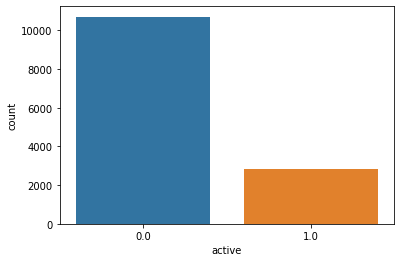

In [39]:
#Test that SMOTE works
sns.countplot(y_train)

In [40]:
## Generate prediction features (for blind test)
predict_features = test_history.merge(trans_features, on='id', how='left')
predict_features.recency.fillna(365, inplace=True)
predict_features.frequency.fillna(0, inplace=True)
predict_features.monetary.fillna(0, inplace=True)
predict_features.mostfrequentday.fillna(0, inplace=True)
predict_features.basketsize.fillna(0, inplace=True)
predict_features.amountaverage.fillna(0, inplace=True)
predict_features.minproductsize.fillna(0, inplace=True)
predict_features.maxproductsize.fillna(0, inplace=True)
predict_features.rangeproductsize.fillna(0, inplace=True)
predict_features.averageproductsize.fillna(0, inplace=True)
predict_features.monetary_std.fillna(0, inplace=True)
predict_features.amt.fillna(0, inplace=True)
predict_features.volume.fillna(0, inplace=True)
predict_features.cummulativeproductsize.fillna(0, inplace=True)
predict_features.promototal.fillna(0, inplace=True)

X_predict = predict_features[x_cols]
predict_out = predict_features[['id', 'active']].copy()

# Build Model

In [41]:
#Final Model
#Paramter Tuning done beforehand
model = RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_impurity_decrease= 0, min_samples_split= 10,random_state=101
)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [42]:
print('Train Accuracy: {:.2f}'.format(model.score(X_train, y_train)))
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Train Accuracy: 0.83
Test Accuracy: 0.80
Test AUC: 0.68


# Generate Prediction

In [43]:
predict_out.head()

,id,active
0,115562959531,0.0
1,264360381954,0.0
2,88674724256,0.0
3,88245158186,0.0
4,135060984132,0.0


In [44]:
predict_out['active'] = model.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,115562959531,0.173014
1,264360381954,0.171604
2,88674724256,0.271741
3,88245158186,0.157992
4,135060984132,0.176401


In [45]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,115562959531,0.173014
1,264360381954,0.171604
2,88674724256,0.271741
3,88245158186,0.157992
4,135060984132,0.176401


In [46]:
# This will download your prediction files
from google.colab import files
files.download('predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>